In [34]:
# Importing the libraries

import pandas as pd
import nixtla
from mlforecast import MLForecast
from mlforecast.lag_transforms import ExpandingMean, RollingMean
from mlforecast.target_transforms import Differences
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from sklearn.ensemble import RandomForestRegressor

import numpy as np

import seaborn as sns




In [3]:
# Load the dataset

df = pd.read_csv('IOT-temp.csv')

# Examine the dataset
print(df.head())

missing_values = df.isnull().sum()
print('Missing Valies', missing_values)

                                    id  room_id/id        noted_date  temp  \
0  __export__.temp_log_196134_bd201015  Room Admin  08-12-2018 09:30    29   
1  __export__.temp_log_196131_7bca51bc  Room Admin  08-12-2018 09:30    29   
2  __export__.temp_log_196127_522915e3  Room Admin  08-12-2018 09:29    41   
3  __export__.temp_log_196128_be0919cf  Room Admin  08-12-2018 09:29    41   
4  __export__.temp_log_196126_d30b72fb  Room Admin  08-12-2018 09:29    31   

  out/in  
0     In  
1     In  
2    Out  
3    Out  
4     In  
Missing Valies id            0
room_id/id    0
noted_date    0
temp          0
out/in        0
dtype: int64


In [4]:
df.dropna()

,id,room_id/id,noted_date,temp,out/in
0,__export__.temp_log_196134_bd201015,Room Admin,08-12-2018 09:30,29,In
1,__export__.temp_log_196131_7bca51bc,Room Admin,08-12-2018 09:30,29,In
2,__export__.temp_log_196127_522915e3,Room Admin,08-12-2018 09:29,41,Out
3,__export__.temp_log_196128_be0919cf,Room Admin,08-12-2018 09:29,41,Out
4,__export__.temp_log_196126_d30b72fb,Room Admin,08-12-2018 09:29,31,In
...,...,...,...,...,...
97601,__export__.temp_log_91076_7fbd08ca,Room Admin,28-07-2018 07:07,31,In
97602,__export__.temp_log_147733_62c03f31,Room Admin,28-07-2018 07:07,31,In
97603,__export__.temp_log_100386_84093a68,Room Admin,28-07-2018 07:06,31,In
97604,__export__.temp_log_123297_4d8e690b,Room Admin,28-07-2018 07:06,31,In


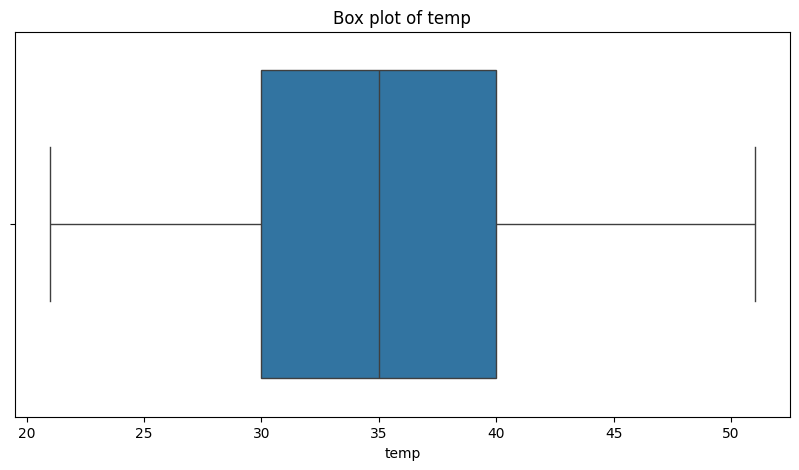

In [5]:

# Select numeric columns for outlier detection
numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns

# Plot box plots for each numeric column
for column in numeric_columns:
    plt.figure(figsize=(10, 5))
    sns.boxplot(x=df[column])
    plt.title(f'Box plot of {column}')
    plt.show()


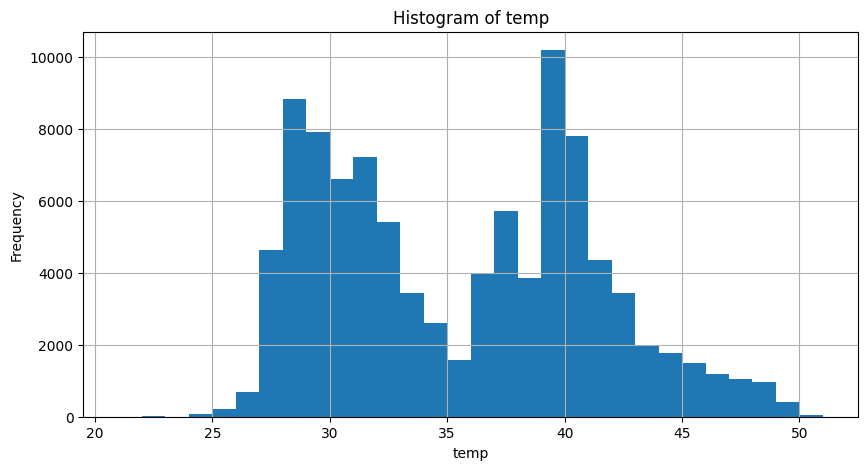

In [6]:
# Plot histograms for each numeric column
for column in numeric_columns:
    plt.figure(figsize=(10, 5))
    df[column].hist(bins=30)
    plt.title(f'Histogram of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.show()


In [7]:

scaler = MinMaxScaler()
df[numeric_columns] = scaler.fit_transform(df[numeric_columns])


                                    id  room_id/id        noted_date  \
0  __export__.temp_log_196134_bd201015  Room Admin  08-12-2018 09:30   
1  __export__.temp_log_196131_7bca51bc  Room Admin  08-12-2018 09:30   
2  __export__.temp_log_196127_522915e3  Room Admin  08-12-2018 09:29   
3  __export__.temp_log_196128_be0919cf  Room Admin  08-12-2018 09:29   
4  __export__.temp_log_196126_d30b72fb  Room Admin  08-12-2018 09:29   

       temp out/in  
0  0.266667     In  
1  0.266667     In  
2  0.666667    Out  
3  0.666667    Out  
4  0.333333     In  


In [8]:
# Split the dataset into Test and Train

# Train-test split based on time series
train_size = int(len(df) * 0.8)
train, test = df[:train_size], df[train_size:]

print(f"Training set: {train.shape}")
print(f"Testing set: {test.shape}")

Training set: (78084, 5)
Testing set: (19522, 5)


In [ ]:
# Check if columns have already been renamed
if 'ds' in df.columns and 'y' in df.columns:
    print("Columns already renamed")
else:
    # Convert 'noted_date' to datetime format
    df['noted_date'] = pd.to_datetime(df['noted_date'], format='%d-%m-%Y %H:%M')

    # Rename columns to match the expected format for MLForecast
    df = df.rename(columns={'noted_date': 'ds', 'temp': 'y'})
    df['unique_id'] = 'temperature_series'  # Assuming a single time series



# Reorder columns to the expected order
df = df[['unique_id', 'ds', 'y']]

# Basic information and statistics
print(df.info())
print(df.describe())

# Train-test split based on time series
train_size = int(len(df) * 0.8)
train, test = df[:train_size], df[train_size:]

print(f"Training set: {train.shape}")
print(f"Testing set: {test.shape}")

# Initialize MLForecast
forecaster = MLForecast(
        models=[
        (RandomForestRegressor(n_estimators=100))
    ],
    freq='D',  # Adjust frequency as per your dataset's granularity
    lags=[1, 2, 3],  # Example lags; modify as needed
    date_features=['year', 'month', 'day'],
    num_threads=4  # Adjust based on your system
)

# Fit the forecaster on the training data
print("Fitting the forecaster...")
forecaster.fit(train)

# Predict on the test data
predictions = forecaster.predict(len(test))


# Evaluate the model
print("Predictions:")
print(predictions_series.head())


In [49]:
# Having issues showing the predictions in the plot


# Plot actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(train['ds'], train['y'], label='Train')
plt.plot(test['ds'], test['y'], label='Test')
plt.plot(test['ds'], predictions, label='Predicted')
plt.legend()
plt.show()

AttributeError: 'DataFrame' object has no attribute 'flatten'